In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2  
import torch

file_path = os.path.join(os.getcwd(), 'bee_wing_photos_isolated')

def read_files(file_path):
    df = pd.DataFrame({
        'serial':[],
        'species':[],
        'side':[],
        'image_path':[]
    })

    for species_name in os.listdir(file_path):
        species_path = os.path.join(file_path, species_name)
        
        for image_name in os.listdir(species_path):
            if not image_name.lower().endswith((".jpg",".png")):
                continue

            image_path = os.path.join(species_path, image_name)

            observation = dict()
            observation['species'] = [species_name]
            observation['image_path'] = [image_path]
            
            start_idx = image_name.find("-")
            end_idx = image_name.find("_")
            observation['serial'] = [image_name[start_idx+1:end_idx]]
            observation['side'] = [image_name[end_idx+1]]

            df = pd.concat([df, pd.DataFrame(observation)])

    df.set_index('serial')
    print('df shape:', df.shape)
    return df 

beewings_df = read_files(file_path)

beewings_df.head()

df shape: (206, 4)


,serial,species,side,image_path
0,IZC00012323,Agapostemon Texanus,R,c:\Users\17075\Desktop\Code for beginner\Proje...
0,IZC00036326,Agapostemon Texanus,R,c:\Users\17075\Desktop\Code for beginner\Proje...
0,IZC00038830,Agapostemon Texanus,R,c:\Users\17075\Desktop\Code for beginner\Proje...
0,IZC00041517,Agapostemon Texanus,R,c:\Users\17075\Desktop\Code for beginner\Proje...
0,IZC00044054,Agapostemon Texanus,R,c:\Users\17075\Desktop\Code for beginner\Proje...


Bombus-Vagans-isolated


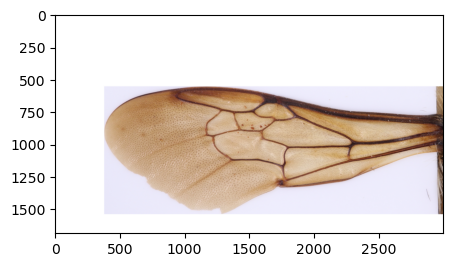

In [429]:
#beewings_df['species'].unique()

#algorithm does poorly against dirty wing species. You can choose to exclude certain species by commenting out the line
species_list = [
    'Agapostemon Texanus', 
    #'Bombus sonorus isolated',
    'Bombus vosnesenskii isolated', 
    'Bombus-Californicus-Isolated',
    'Bombus-Melangypus-Isolated', 
    'Bombus-Vagans-isolated',
    'Diadasia bituberculata-isolated', 
    'Diadasia-australis-isolated',
    'Eucera frater albopilosa-isolated',
    'Habropoda- tristissima-Isolated', 
    'Habroporda Depressa-Isolated',
    'Isolated Xylocopa tabaniformis orpifex',
    'Megachile onobrychidis-isolated', 
    'Osmia-Aglaia-Isolated',
    'Xylocopa tabaniformis orpifex',
    ]

df = beewings_df[beewings_df['species'].isin(species_list)]

#grab random image
rand = df[['species','image_path']].iloc[np.random.randint(0, len(df))]
print(rand['species'])
test_image = cv2.imread(rand['image_path'])
plt.figure(figsize=(5,5))
plt.imshow(test_image[:,:,::-1])


image shape: (281, 500, 3)


array([  0, 255], dtype=uint8)

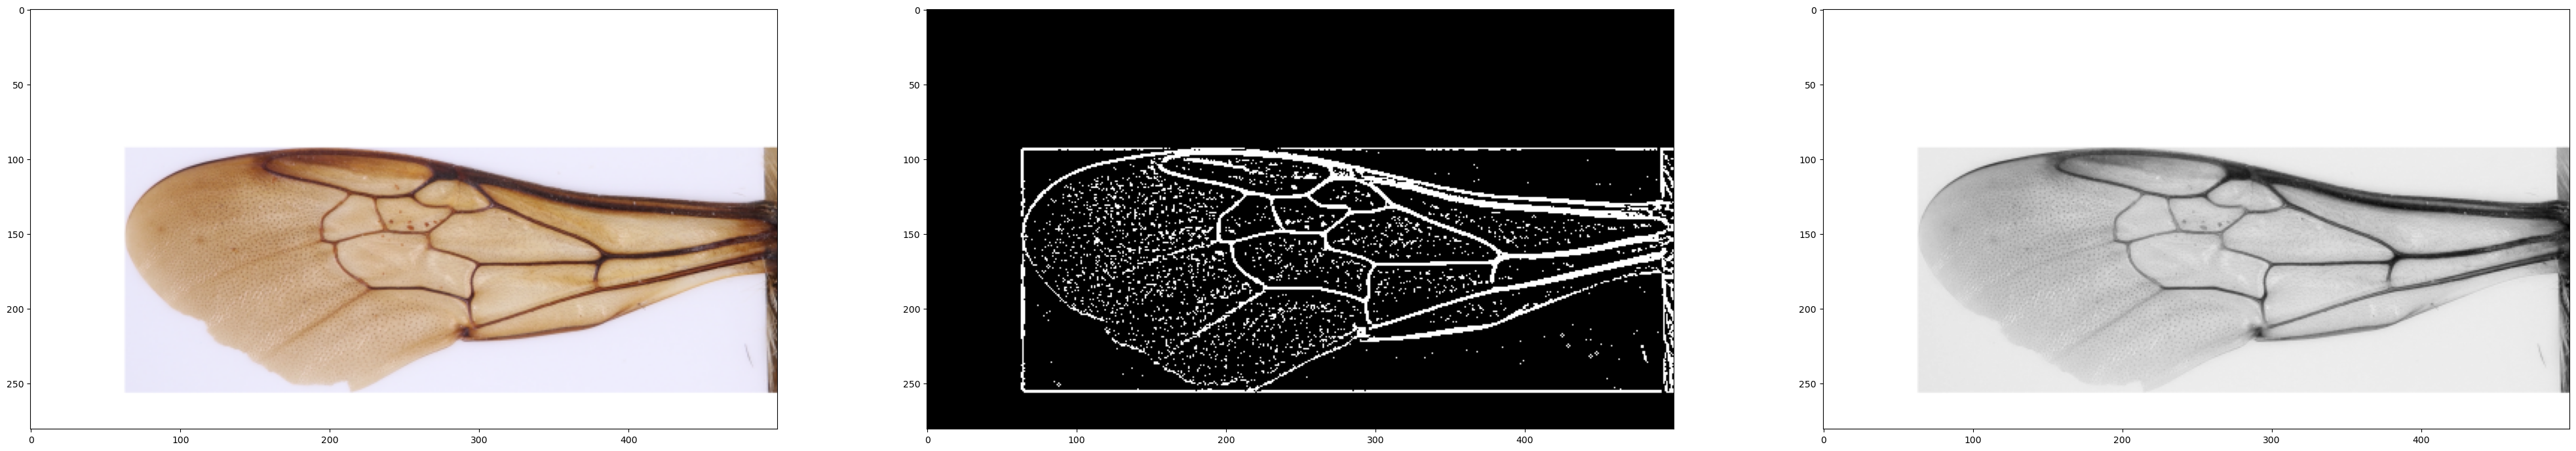

In [431]:
image_chosen = test_image.copy()
r = 500.0 / image_chosen.shape[1]
dim = (500, int(image_chosen.shape[0] * r))
image_chosen = cv2.resize(image_chosen, dim, interpolation=cv2.INTER_AREA)

#Original Image
plt.figure(figsize=(50,50))
plt.subplot(3,3,1)
plt.imshow(image_chosen[:,:,::-1])
print('image shape:',image_chosen.shape)


#gray scale + bluring. 
image_chosen_gray = cv2.cvtColor(image_chosen, cv2.COLOR_BGR2HSV)[:,:,-1]
#image_chosen_gray = cv2.cvtColor(image_chosen, cv2.COLOR_BGR2GRAY)
image_chosen_gray = image_chosen[:,:,-1].copy()

#image_chosen_gray = cv2.fastNlMeansDenoising(image_chosen_gray, h=10, templateWindowSize=7, searchWindowSize=21)


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
#image_chosen_gray = clahe.apply(image_chosen_gray)

se=cv2.getStructuringElement(cv2.MORPH_RECT , (3,3))
bg=cv2.morphologyEx(image_chosen_gray, cv2.MORPH_DILATE, se)
#image_chosen_gray=cv2.divide(image_chosen_gray, bg, scale=255)



image_chosen_gray_blur = cv2.medianBlur(image_chosen_gray,3)
image_chosen_gray_blur = cv2.bilateralFilter(image_chosen_gray_blur, 3, 50, 50)



divide = cv2.divide(image_chosen_gray, image_chosen_gray_blur, scale=255)

th = cv2.adaptiveThreshold(image_chosen_gray_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,3,1,)

plt.subplot(3,3,2)
plt.imshow(th, cmap='gray')




_, th2 = cv2.threshold(divide,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(3,3,3)
plt.imshow(image_chosen_gray, cmap='gray')
np.unique(th2)


45


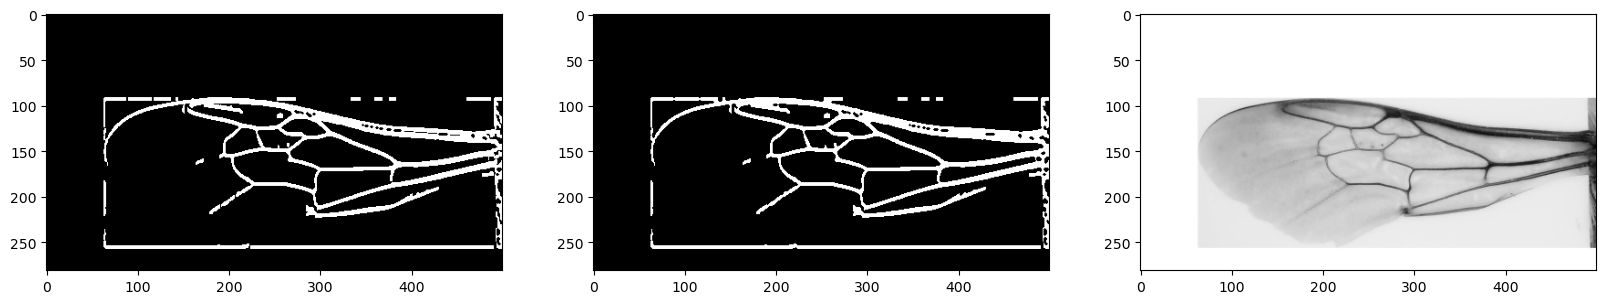

In [432]:
plt.figure(figsize=(20,20))
#Noise reduce and dilation: step 3
noise_remove = th.copy()

noise_remove = cv2.medianBlur(noise_remove, 3)
noise_remove = cv2.dilate(noise_remove, np.full(3,3),255)
contours, hierarchy = cv2.findContours(noise_remove, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE,)
filtered_contours = [i for i in contours if cv2.contourArea(i) < 20]
noise_remove = cv2.drawContours(noise_remove, filtered_contours, -1, 0, cv2.FILLED)

#nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(noise_remove)
#sizes = stats[:, -1]
#sizes = sizes[1:]
#nb_blobs -= 1
#min_size = 50
## output image with only the kept components
#im_result = np.zeros_like(im_with_separated_blobs)
## for every component in the image, keep it only if it's above min_size
#for blob in range(nb_blobs):
#    if sizes[blob] >= min_size:
#        # see description of im_with_separated_blobs above
#        im_result[im_with_separated_blobs == blob + 1] = 255
#
#noise_remove = im_result.copy().astype('uint8')
#


contours, _ = cv2.findContours(noise_remove, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE,)
print(len(contours))


plt.subplot(3,3,4)
plt.imshow(noise_remove, cmap='gray')
kernel = np.full((5,5), 255)
#noise_remove = cv2.dilate(noise_remove, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
noise_remove = cv2.morphologyEx(noise_remove, cv2.MORPH_CLOSE, kernel, iterations=1)

plt.subplot(3,3,5)
plt.imshow(noise_remove, cmap='gray')

### return by grayscale!!
sharpened_image = np.zeros_like(image_chosen_gray)
sharpened_image[noise_remove == 255] = image_chosen_gray[noise_remove == 255]
sharpened_image[noise_remove == 0] = image_chosen_gray_blur[noise_remove == 0]

plt.subplot(3,3,6)
plt.imshow(sharpened_image, cmap='gray')



13


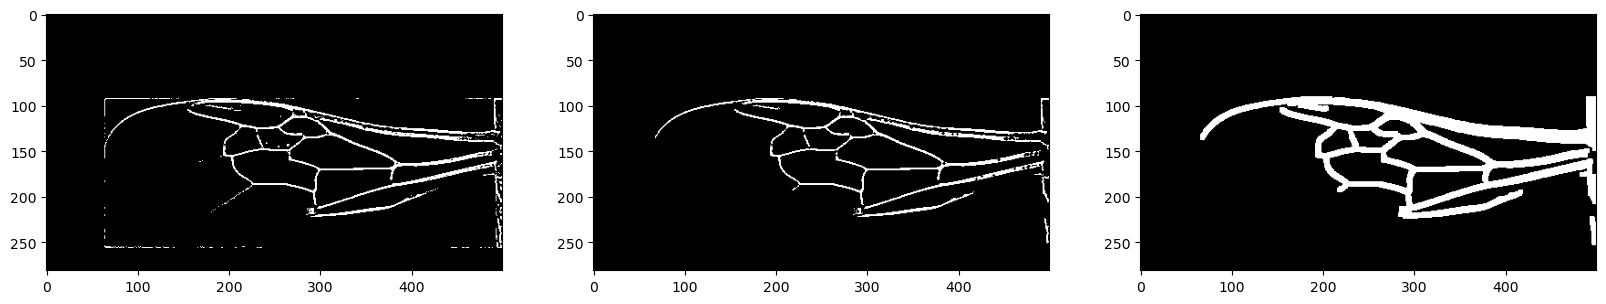

In [433]:
plt.figure(figsize=(20,20))

#Repeat step 2 and 3 
sharpened_image_copy = sharpened_image.copy()

sharpened_image_copy = cv2.medianBlur(sharpened_image_copy,3)
sharpened_image_copy = cv2.bilateralFilter(sharpened_image_copy, 3, 50, 50)


th = cv2.adaptiveThreshold(sharpened_image_copy,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,3,2,)
noise_remove = th.copy()

plt.subplot(3,3,7)
plt.imshow(noise_remove, cmap='gray')


#noise_remove = cv2.medianBlur(noise_remove, 3)


contours, _ = cv2.findContours(noise_remove, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE,)
filtered_contours = [i for i in contours if cv2.contourArea(i) < 10]
noise_remove = cv2.drawContours(noise_remove, filtered_contours, -1, 0, cv2.FILLED)



plt.subplot(3,3,8)
plt.imshow(noise_remove, cmap='gray')


#noise_remove = cv2.dilate(noise_remove, np.full((3,3),255))
#noise_remove = cv2.erode(noise_remove, np.full((3,3),255))
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
#noise_remove = cv2.morphologyEx(noise_remove, cv2.MORPH_CLOSE, kernel, iterations=1)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
noise_remove = cv2.morphologyEx(noise_remove, cv2.MORPH_DILATE, kernel, iterations=1)

des = cv2.bitwise_not(noise_remove)
contour,hier = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
print(len(contour))
filtered_contours = [i for i in contour if cv2.contourArea(i) < 200]
for cnt in filtered_contours:
    cv2.drawContours(des,[cnt],0,0,-1)
noise_remove = cv2.bitwise_not(des)

#noise_remove = cv2.GaussianBlur(noise_remove, (3,3), 0)

plt.subplot(3,3,9)
plt.imshow(noise_remove, cmap='gray')

## thinning, https://github.com/linbojin/Skeletonization-by-Zhang-Suen-Thinning-Algorithm




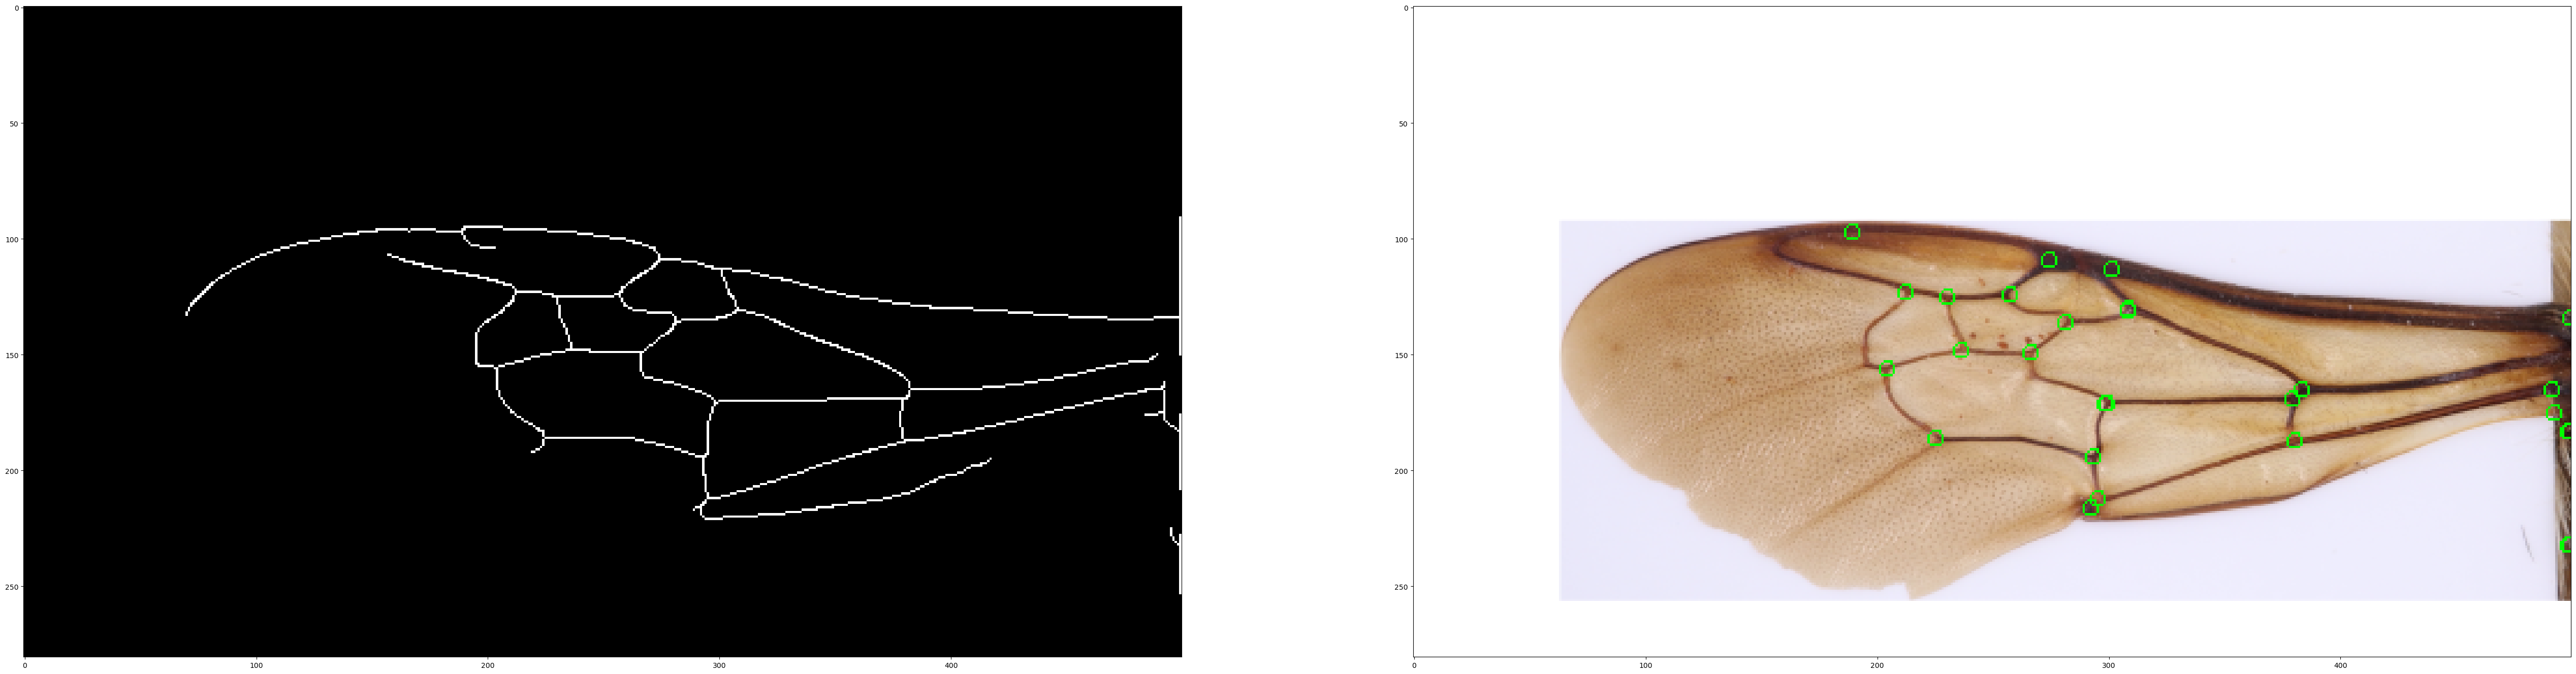

In [434]:
from thin import zhangSuen, get_corners
skinny = zhangSuen(noise_remove/255) * 255
skinny = skinny.astype('uint8')
img = image_chosen.copy()

plt.figure(figsize=(100,100))
corn = get_corners(skinny)
plt.subplot(3,3,2)
plt.imshow(skinny, cmap='gray')

coordinates = np.argwhere(corn)
for c in coordinates:
    cv2.circle(img, c[::-1], 3, (0,255,0), 1, lineType=cv2.FILLED)

plt.subplot(3,3,3)
plt.imshow(img[:,:,::-1])
